![MOSEK ApS](https://www.mosek.com/static/images/branding/webgraphmoseklogocolor.png )

# Piece-wise linear approximation of a convex function

It is clear that each convex function can be approximated to some extent by a convex piece-wise linear function. In this notebook we show how to model this as a least squares problem. This model was introduced and studied by [Kuosmanen](https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1368-423X.2008.00239.x) and [Seijo, Sen](https://projecteuclid.org/journals/annals-of-statistics/volume-39/issue-3/Nonparametric-least-squares-estimation-of-a-multivariate-convex-regression-function/10.1214/10-AOS852.full), among others.

We are given a set of points $X_1,\ldots,X_n\in \mathbb{R}^d$ and $Y_1,\ldots,Y_n\in\mathbb{R}$, which we presume were generated as $Y_i = f(X_i) + \varepsilon_i$ where $f$ is a convex function and $\varepsilon_i$ is noise. Our least squares problem looks as follows 

$$\begin{array}{rll}
\text{minimize} & \sum_{i=1}^n (t_i - Y_i)^2 & \\
\text{subject to} & t_i \geq t_j + s_j^T (X_i - X_j) &\text{for all}\ 1\leq i,j\leq n, \\
& t_1, ..., t_n \in \mathbb{R}, & \\
& s_1, ..., s_n \in \mathbb{R}^d. &
\end{array}$$

Then the piecewise linear function approximating the data will be defined as the maximum $\Theta(x)=\text{max}\{\Theta_i(x),\ i=1,\ldots,n\}$ of $n$ linear functions $\Theta_i:\mathbb{R}^d\to \mathbb{R}$ given by

$$\Theta_i(x) = t_i + s_i^T(x-X_i)$$

for $i=1,\ldots,n$.

Note that $\Theta_i(X_i)=t_i$ and $\nabla \Theta_i(X_i)=s_i$. Therefore the main constraint appearing in the model represents precisely the convexity requirement:

$$\Theta(X_i) - \Theta(X_j) \geq \langle\nabla \Theta(X_j),X_i-X_j\rangle$$

for the function $\Theta$.

### Preparing synthetic data

In the example we will show an approximation of a simple quadratic function $f(x) = x^Tx.$

Let us first define our data. We generate $n$ points of dimension $d$ uniformly from $[-1, 1]^d$. The corresponding respose is given as $Y_i = f(X_i) + \varepsilon_i$. Error $\varepsilon$ follows normal distribution $N(0, \sigma^2 I_n)$, where $\sigma^2 = Var(f(\mathbf{X})) / SNR$ and $SNR = 3$. Lastly, we mean-center and standardize to unit $l_2$ norm the responses $Y$ and the data $X$. We do this to get a more predictive model.

In [1]:
import numpy as np
from mosek.fusion import *
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]
from matplotlib import cm
import sys

In [2]:
np.random.seed(0)

# specify the dimension
n = 200 
d = 2

# specify the function
fun = lambda x: np.sum(np.multiply(x, x), 1)   # x^T x

# generate data and get corresponding responses
x = np.random.uniform(-1, 1, n*d).reshape(n, d)
response = fun(x)

# compute response vector with error
varResponse = np.var(response, ddof=1)  # unbiased sample variance
SNR = 3
stdError = np.sqrt(varResponse / SNR)
error = np.random.normal(0, stdError, n)
reponseWithError = response + error

# standardize and mean-center the response
meanY = np.sum(reponseWithError) / n
standY = reponseWithError - meanY
norm = np.sqrt( np.sum( np.square( standY )))
Y = standY / norm

# standardize the x (by the dimension) and mean-center
meanX = np.sum(x, axis=0) / n
standX = x - meanX
norm = np.sqrt(np.sum (np.square( standX ), axis=0))
X = np.divide(standX, norm)


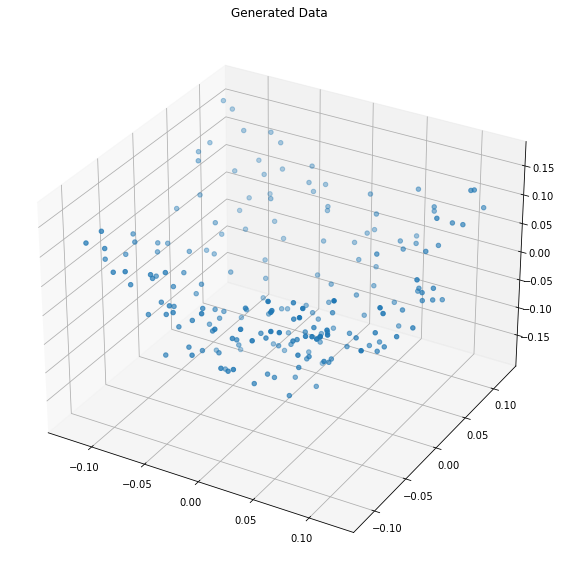

In [3]:
# Plot generated data
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# set title
ax.set_title("Generated Data")

# scatter old points
scatter = ax.scatter(X[:, 0], X[:, 1], Y)

### Fusion Model
In the following block, usage of Mosek Fusion for Python for this case is presented.

In [4]:
# solve QP
with Model('ConvexApproxLeastSquares') as M:

    ############## create variables ##############

    m =  M.variable( 1, Domain.unbounded() )       # maximum variable
    t =  M.variable( n, Domain.unbounded() )      
    ss = M.variable( [n, d], Domain.unbounded() )  # variables s stored in n X d matrix

    ############## create constraints ##############

    # create Qr constraints

    # auxDiff = t - ys
    auxDiff = M.variable( n, Domain.unbounded() )
    M.constraint( Expr.sub(t, auxDiff), Domain.equalsTo(Y) )

    # (0.5, m, t - ys) in Q_r
    auxHalf = M.variable( 1, Domain.equalsTo(0.5) )
    z1 = Var.vstack( auxHalf, m, auxDiff )
    M.constraint( z1, Domain.inRotatedQCone() )

    # create constraints on the maximum of the linear-piecewise functions
    # i.e.    
    #       0 >= t_j - t_i + <s_j,x_i - x_j>

    # compute t_j - t_i
    t_is = Expr.flatten( Expr.repeat(t, n, 1) )
    t_js = Expr.repeat( t, n, 0 )

    Diff = Expr.sub(t_js, t_is)

    # make a dot product <s_j,x_i - x_j>
    x_is = np.repeat( X, repeats=n, axis=0 )
    x_js = np.tile( X, (n, 1) )
    ss_stack = Expr.repeat( ss, n, 0 )

    dotProd = Expr.sum( Expr.mulElm(ss_stack ,x_is - x_js) , 1 )   # dot product  
    
    # add constraint
    expr = Expr.add(Diff, dotProd)
    M.constraint( expr, Domain.lessThan(0) )

    ############## solve problem ##############

    # minimize the least squares
    M.objective( "obj", ObjectiveSense.Minimize, m )    

    # set the log handler to stdout
    M.setLogHandler(sys.stdout)

    M.solve()

    # get the optimal values
    solt = t.level()
    sols = ss.level().reshape((n, d))

Problem
  Name                   : ConvexApproxLeastSquares
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 40200           
  Affine conic cons.     : 1               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 803             
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 200
Eliminator terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 2                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Pres

### Model evalutation

Let us evaluate our fit, this can be done as follows

$\hat \phi (\mathbf{x}) = \max \limits _{1 \leq j \leq n} \{ \hat{t}_j + \hat{s}_j^T (\mathbf{x} - X_j) \}$
    
We can now see obvious drawback of such method; we need to keep all points. Please note that code below is not vectorized for the educational purposes but should be if aiming for efficiency.

In [5]:
# create points for evaluation
n = 100
xs = np.linspace(-.1, .1, n)
ys = np.linspace(-.1, .1, n)

xx, yy = np.meshgrid(xs, ys)
x = np.c_[xx.reshape(xx.size, 1), yy.reshape(yy.size, 1)]
x = x.astype(np.double)

# get number of linear functions
numberOfLinearFuns = solt.size

# evaluate data
phi = np.zeros(n**2)

for i in range(0, n**2):

    possibleValues = np.zeros(numberOfLinearFuns)
    for j in range(0, numberOfLinearFuns):
        
        # max_j { t_j + <s_j , x_i - X_j> }
        val = solt[j] + np.dot(sols[j, :], x[i, :] - X[j, :])
        possibleValues[j] = val

    phi[i] = np.max(possibleValues)

### Plot the results
Finally, we can plot our solution. 

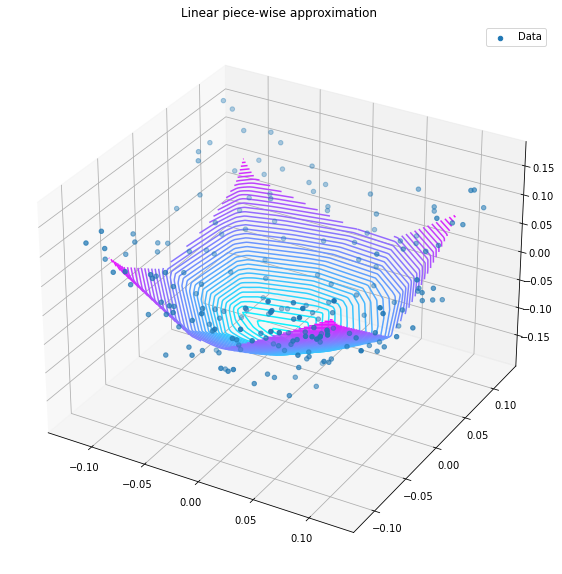

In [6]:
# create plot
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# set title
ax.set_title("Linear piece-wise approximation")

# scatter old points
ax.scatter(X[:, 0], X[:, 1], Y)

# plot the model
xx = x[:, 0].reshape(n, n)
yy = x[:, 1].reshape(n, n)
zz = phi.reshape(n, n)
axs = ax.contour3D(xx, yy, zz, 50, cmap=cm.cool)

# set the legend
leg = ax.legend(["Data"])

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/80x15.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>. The **MOSEK** logo and name are trademarks of <a href="http://mosek.com">Mosek ApS</a>. The code is provided as-is. Compatibility with future release of **MOSEK** or the `Fusion API` are not guaranteed. For more information contact our [support](mailto:support@mosek.com). 